Código principal.


Se establecen las condiciones iniciales y se hacen los cálculos fijos. Después se definen varias funciones. La función principal es main, que realiza la evolución del sistema.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
from numpy import random as randomp
from random import seed
from random import random
from datetime import datetime
from numba import jit

#semilla para num aleatorios
now = datetime.now()
seed(now.microsecond)
#randomp.seed(now.microsecond)



#paso 0 (inicializar) globales

npart=20
paso=npart*npart
p=20
sp=randomp.choice([0,1],size=(npart,npart)) 


#patron
patron1=np.loadtxt("patron1.txt")
uno=np.loadtxt("unouno.txt")
dos=np.loadtxt("dosdos.txt")
tres=np.loadtxt("tres.txt")
cuatro=np.loadtxt("cuatro.txt")
#patron1=randomp.choice([0,1],size=(npart,npart))
zeta=randomp.choice([0,1],size=(p,npart,npart))
###patrones prefijados
# zeta[0]=uno
# zeta[1]=dos
# zeta[2]=tres
# zeta[3]=cuatro
# for k in range(npart):
#     for j in range(npart//2):
#         zeta[0][k][j+15]=randomp.choice([0,1],size=1)
#         zeta[1][k][j]=randomp.choice([0,1],size=1)
# for k in range(npart//2):
#     for j in range(npart):        
#         zeta[2][k+15][j]=randomp.choice([0,1],size=1)
#         zeta[3][k][j]=randomp.choice([0,1],size=1)



#patron a archivo
g=open("patron.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(zeta[0][j][k])+", ",end="", file=g)
        else:
            print(zeta[0][j][k],end="", file=g)
    print("\n",end='',file=g)
    
g.close()

h=open("salida0.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(sp[j][k])+", ",end="", file=h)
        else:
            print(sp[j][k],end="", file=h)
    print("\n",end='',file=h)
        
h.close()



theta=np.zeros((npart,npart))
                
                
                
    
##################suma de a
a=np.zeros(p)
for l in range(p):
    for i in range (npart):
        for j in range (npart):
            a[l]=a[l]+zeta[l][i][j]      
a=a/(npart*npart)
        
@jit(nopython=True)  ##El @jit es un de paquete que permite no tener que cargar las funciones en cada llamada,
def omega(i,j,k,l):  ##si no que se asemejan a como funcionan en C++, optimizando considerablemente el tiempo de cálculo.
    suma=0
    if ((i!=k) or (j!=l)):
        for n2 in range (p):
            suma=suma+(zeta[n2][i][j]-a[n2])*(zeta[n2][k][l]-a[n2])
    return suma/(npart*npart)
omeg=np.zeros((npart,npart,npart,npart))
for i in range(npart):
    for j in range(npart):
        for k in range(npart):
            for l in range(npart):
                omeg[i][j][k][l]=omega(i,j,k,l)
#umbral de disparo:(calculamos una vez todos los umbrales de disparo para no tener que calcularlos en cada iteración,
# ya que es fijo a partir de los patrones) 
for i in range(npart):
    for j in range(npart):
        for k in range(npart):
            for l in range(npart):
                theta[i][j]=theta[i][j]+omeg[i,j,k,l]
theta=0.5*theta                
###################


######### calculo del hamiltoniano #######
@jit(nopython=True)
def hamilton1(s):
    suma1=0
    suma2=0
    for i in range (npart):
        for j in range (npart):
            suma2=suma2+theta[i][j]*s[i][j]
            for k in range(npart):
                for l1 in range(npart):
                    suma1=suma1+omeg[i,j,k,l1]*s[i][j]*s[k][l1]

    return -0.5*suma1+suma2
#########################################
@jit(nopython=True)
def hamilton(s,a,b):
    suma=0
    for i in range(npart):
        if(i!=a):
            for j in range(npart):
                if(j!=b):
                    suma=suma+omeg[i][j][a][b]*s[i][j]
                
    return (1-2*s[a][b])*(theta[a][b]-0.5*omeg[a][b][a][b]-suma)


########### calculo del solapamiento
@jit(nopython=False)
def solapamiento(s,pos):
    suma=0
    for i in range(npart):
        for j in range(npart):
            suma=suma+(zeta[pos][i][j]-a[pos])*(s[i][j]-a[pos])
    
    return suma/(npart*npart*a[pos]*(1-a[pos]))


############################
def main(t,montec,difuminado,dif):
#variables de la función
    itera=montec*paso #numero iteraciones

    s=np.copy(sp)

    if(difuminado==True):  #Para modificar el estado inicial y hacer que fuese el patrón difuminado
        for i in range(npart):
            for j in range(npart):
                chi=random()
                if(chi<dif):
                    s[i][j]=zeta[0][i][j]

    
    positera=np.zeros((itera//paso+1))
    gsolap=np.zeros((p,itera//paso+1))

    for i in range(itera+1):
        n = randomp.randint(npart)
        m = randomp.randint(npart)


      
        minimo=min(1,np.exp(-hamilton(s,n,m)/t))

      

        xi=random()
       

        if(xi<minimo):
            if(s[n][m]==0):
                s[n][m]=1
            else:
                s[n][m]=0
        
        ###Aquí se guardan la red en cada paso monte carlo para luego poder estudiar la evolución
        if(i%paso==0):
            positera[i//paso]=i/paso
            for k in range(p):
                gsolap[k][i//paso]=(solapamiento(s,k)) 
        
        
        if(i%paso==0):
            f=open("salida"+str(i//paso+1)+".dat","w")
            #print(s) 
            for j in range(npart):
                for k in range(npart):
                    if(k!=npart-1):
                        print(str(s[j][k])+", ",end="", file=f)
                    else:
                        print(s[j][k],end="", file=f)

                print("\n",end='',file=f)

                #print("\n",end='',file=f)

    
    f.close()
    
    vecsolap=np.zeros(p)
    for i in range(p):
        vecsolap[i]=solapamiento(s,i)

    
    #return vecsolap ----------- Para estudiar el solapamiento final
    #return ((positera,gsolap) ----------- Para estudiar el solapamiento en cada paso Monte Carlo
   

#%prun main()

Bloque que se utilizó para las primeras figuras de T=10e-4. No funciona ya que luego se modificó el código para optimizarlo.

NameError: name 'positera' is not defined

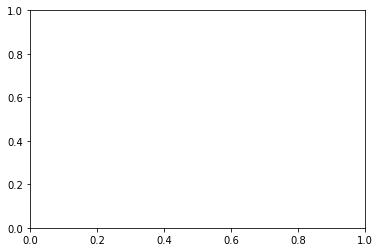

In [139]:


x = np.linspace(0, 8, 8)  # Sample data.
y=np.full(8,1)
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots()
main(0.1,10,False,0)
ax.plot(positera[0:9], nodifuminado3[0:9],'gx', label='Difuminado 30%')  # Plot some data on the axes.
ax.plot(x,y)
ax.set_xlabel('Pasos montecarlo')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([3,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
#ax.legend();  # Add a legend.
#plt.savefig('1i.png')
print(positera,gsolap)

Aquí se define la función "dibujar", a partir del algoritmo de la animación de Ising. Se ha utilizado para ver la evolución del sistema en cada paso Monte Carlo.

In [13]:
# ================================================================================
# ANIMACION ISING
#
# Genera una animación a partir de un fichero de datos con la configuración
# del retículo en cada instante de tiempo
# 
# El fichero debe estructurarse de la siguiente forma:
# 
#   s(1,1)_1, s(1,2)_1, ..., s(1,M)_1
#   s(2,1)_1, s(2,2)_1, ..., s(2,M)_1
#   (...)
#   s(N,1)_1, s(N,2)_1, ..., s(N,M)_1
#   
#   s(1,1)_2, s(1,2)_2, ..., s(1,M)_2
#   s(2,1)_2, s(2,2)_2, ..., s(2,M)_2
#   (...)
#   s(N,1)_2, s(N,2)_2, ..., s(N,M)_2
#
#   s(1,1)_3, s(1,2)_3, ..., s(1,M)_3
#   s(2,1)_3, s(2,2)_3, ..., s(2,M)_3
#   (...)
#   s(N,1)_3, s(N,2)_3, ..., s(N,M)_3
#   
#   (...)
#
# donde s(i,j)_k es el valor del spin en la fila i-ésima y la columna
# j-ésima en el instante k. M es el número de columnas y N el número
# de filas en el retículo. Los valores del spin deben ser +1 ó -1.
# El programa asume que las dimensiones del retículo no cambian a lo
# largo del tiempo.
# 
# Si solo se especifica un instante de tiempo, se genera una imagen en pdf
# en lugar de una animación
#
# Se puede configurar la animación cambiando el valor de las variables
# de la sección "Parámetros"
#
# ================================================================================

# Importa los módulos necesarios
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
import io
def dibujar(x,i):
    # Parámetros
    # ========================================
    file_in = x # Nombre del fichero de datos
    file_out = "patron"+str(i) # Nombre del fichero de salida (sin extensión)
    interval = 100 # Tiempo entre fotogramas en milisegundos
    save_to_file = True # False: muestra la animación por pantalla,
                        # True: la guarda en un fichero
    dpi = 150 # Calidad del vídeo de salida (dots per inch)


    # Lectura del fichero de datos
    # ========================================
    # Lee el fichero a una cadena de texto
    with open(file_in, "r") as f:
        data_str = f.read()

    # Inicializa la lista con los datos de cada fotograma.
    # frames_data[j] contiene los datos del fotograma j-ésimo
    frames_data = list()

    # Itera sobre los bloques de texto separados por líneas vacías
    # (cada bloque corresponde a un instante de tiempo)
    for frame_data_str in data_str.split("\n\n"):
        # Almacena el bloque en una matriz
        # (io.StringIO permite leer una cadena de texto como si fuera un
        # fichero, lo que nos permite usar la función loadtxt de numpy)
        frame_data = np.loadtxt(io.StringIO(frame_data_str), delimiter=",")

        # Añade los datos del fotograma (la configuración del sistema)
        # a la lista
        frames_data.append(frame_data)

    # Creación de la animación/gráfico
    # ========================================
    # Crea los objetos figure y axis
    fig, ax = plt.subplots()

    # Define el rango de los ejes
    ax.axis("off")  # No muestra los ejes

    # Representa el primer fotograma
    im = ax.imshow(frames_data[0], cmap="binary", vmin=-1, vmax=+1)
    
    # Función que actualiza la configuración del sistema en la animación
    def update(j_frame, frames_data, im):
        # Actualiza el gráfico con la configuración del sistema
        im.set_data(frames_data[j_frame])

        return im,

    # Calcula el nº de frtogramas o instantes de tiempo
    nframes = len(frames_data)

    # Si hay más de un instante de tiempo, genera la animación
    if nframes > 1:
        animation = FuncAnimation(
                fig, update,
                fargs=(frames_data, im), frames=len(frames_data), blit=True, interval=interval)

        # Muestra por pantalla o guarda según parámetros
        if save_to_file:
            animation.save("{}.mp4".format(file_out), dpi=dpi)
        else:
            plt.show()
    # En caso contrario, muestra o guarda una imagen
    else:
        # Muestra por pantalla o guarda según parámetros
        if save_to_file:
            fig.savefig("{}.png".format(file_out))
        else:
            plt.show()

Pequeño algoritmo para mostrar la evolución del sistema en los primeros 20 pasos Monte Carlo.

C:\Users\aula\AppData\Local\Temp\ipykernel_15372\586014636.py:82: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()


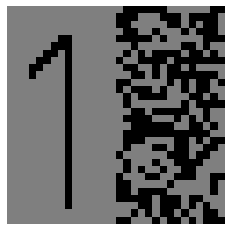

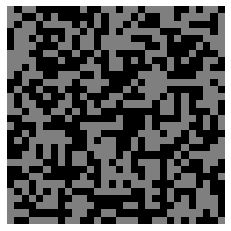

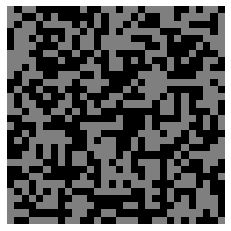

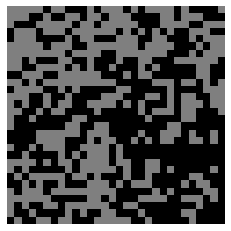

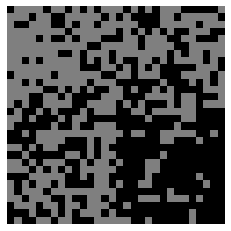

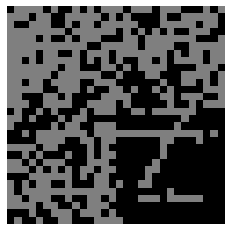

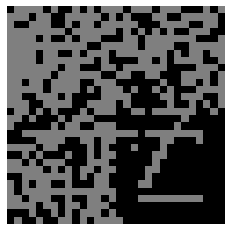

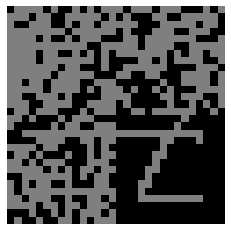

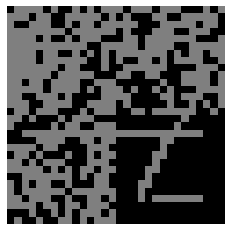

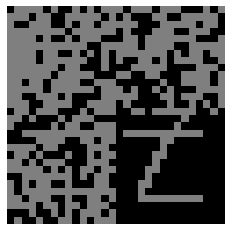

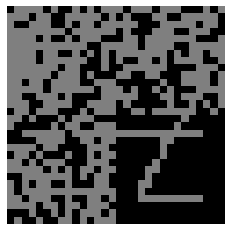

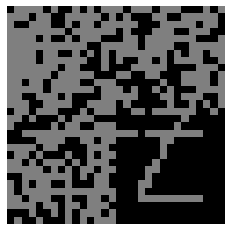

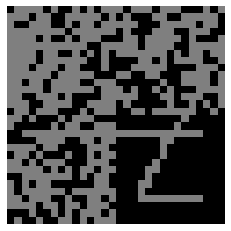

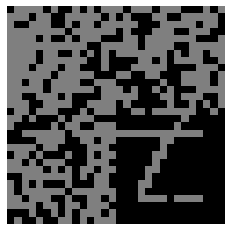

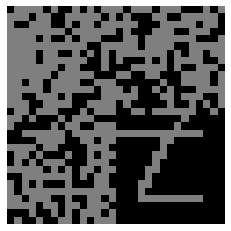

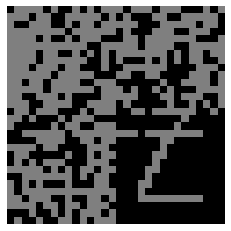

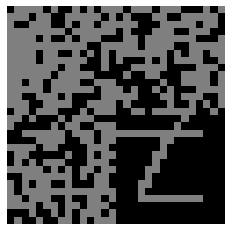

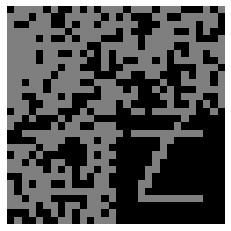

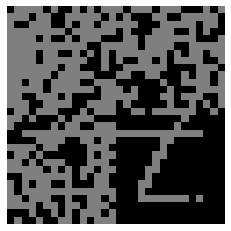

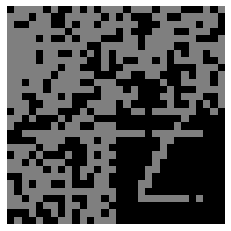

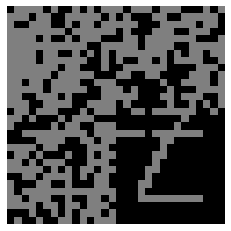

In [14]:
dibujar("patron.dat",100)
for i in range(20):
    nombre="salida"+str(i)+".dat"
    dibujar(nombre,i)

Las siguientes celdas se han utilizado para realizar las diferentes gráficas. La mayoría no funcionan ya que para cada una la salida de la función es un poco diferente.

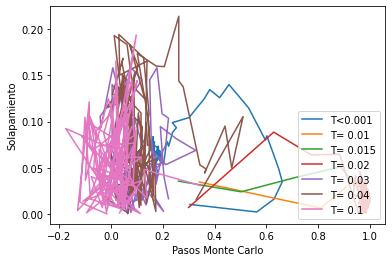

In [2]:

# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots()
nmontes=100

#temp = np.logspace(-4, 0,npuntos) # Sample data.
t=[0.001,0.01,0.015,0.02,0.03,0.04,0.1]

npasos=len(t)
#aux=np.zeros((npuntos,npasos))
#print((main(t[0],nmontes,False,0)))
for i in range(npasos):
    if(i==0):
        etiqueta='T<0.001'
    else:
        etiqueta='T= '+str(t[i])
    aux=(main(t[i],nmontes,True,0.3))
    ax.plot(aux[0],abs(aux[1]),label=etiqueta)
     
#for j in range(npasos):
    #if (j==0):
        #etiqueta='1 paso'
    #else:
        #etiqueta=str(j+1)+' pasos'
    #ax.plot(temp, aux[:,j],"x", label=etiqueta)
#ax.plot(x,y)
ax.set_xlabel('Pasos Monte Carlo')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend(loc='lower right');  # Add a legend.
#plt.savefig('1i.png')
#plt.xscale("log")



C:\Users\aula\AppData\Local\Temp\ipykernel_20940\661483410.py:165: RuntimeWarning: overflow encountered in exp
  minimo=min(1,np.exp(-hamilton(s,n,m)/t))


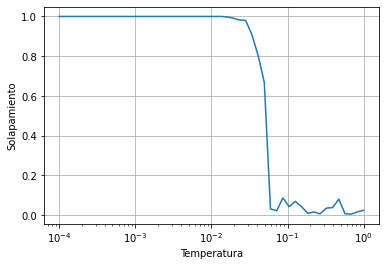

In [8]:
#solapamiento frente a t
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots()
npuntos=50
nmuestras=1
temp = np.logspace(-4, 0,npuntos) # Sample data.
aux=np.zeros(npuntos)
for i in range(npuntos):
    for k in range(nmuestras):
        aux[i]=aux[i]+abs(main(temp[i],20,False,0.7))
aux=aux/nmuestras

ax.plot(temp, aux)
#ax.plot(x,y)
ax.set_xlabel('Temperatura')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
#ax.legend();  # Add a legend.
#plt.savefig('1i.png')
plt.xscale("log")
plt.grid(True)




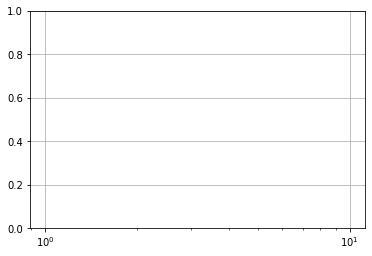

In [37]:
ax.plot(temp, aux)
#ax.plot(x,y)
ax.set_xlabel('Temperatura')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
#ax.legend();  # Add a legend.
#plt.savefig('1i.png')
plt.xscale("log")
plt.grid(True)

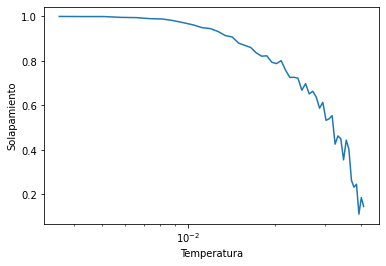

In [11]:
# Note that even in the OO-style, we use `.pyplot.figure` to create the Figure.
fig, ax = plt.subplots()
npuntos=50
nmuestras=3
temp = np.linspace(3.55*10**-3, 4.09*10**-2,npuntos) # Sample data.
aux=np.zeros(npuntos)
for i in range(npuntos):
    for k in range(nmuestras):
        aux[i]=aux[i]+abs(main(temp[i],100,False,0))
aux=aux/nmuestras

ax.plot(temp, aux)
#ax.plot(x,y)
ax.set_xlabel('Temperatura')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
#ax.legend();  # Add a legend.
#plt.savefig('1i.png')
plt.xscale("log")
plt.grid(False)



In [16]:
a=0.02870408
b=0.0340398
ntemp=50
temp=np.random.rand(ntemp)
temp=(b-a)*temp+a
nmuestras=10
contador=0
suma1=0
suma2=0
for i in range(ntemp):
    aux=0
    for j in range(nmuestras):
        aux=aux+main(temp[i],100,False,0)
    aux=aux/nmuestras
    if(aux>0.45 and aux<0.55):
        print("ole")
        contador=contador+1
        suma1=suma1+temp[i]
        suma2=suma2+aux

suma1=suma1/contador
suma2=suma2/contador
print(suma1,suma2)

ZeroDivisionError: division by zero

C:\Users\aula\AppData\Local\Temp\ipykernel_28236\1433026379.py:165: RuntimeWarning: overflow encountered in exp
  minimo=min(1,np.exp(-hamilton(s,n,m)/t))


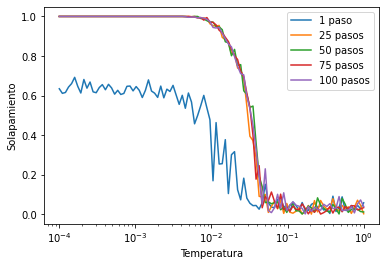

In [136]:
fig, ax = plt.subplots()
npuntos=100
npasos=5
temp = np.logspace(-4, 0,npuntos) # Sample data.
aux=np.zeros((npuntos,npasos))
for j in range(npasos):
    for i in range(npuntos):
        if (j==0):
            aux[i][j]=abs(main(temp[i],1,False,0))
        else:
            aux[i][j]=abs(main(temp[i],j*25,False,0))
        
for j in range(npasos):
    if (j==0):
        etiqueta='1 paso'
    else:
        etiqueta=str(j*25)+' pasos'
    ax.plot(temp, aux[:,j], label=etiqueta)
#ax.plot(x,y)
ax.set_xlabel('Temperatura')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend();  # Add a legend.
#plt.savefig('1i.png')
plt.xscale("log")


In [118]:
%prun main(0.999,1000,False,0)

         9162338 function calls in 22.076 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    6.800    6.800   22.076   22.076 349817279.py:121(main)
   900001    6.706    0.000    6.706    0.000 349817279.py:97(hamilton)
  1800002    5.850    0.000    5.850    0.000 {method 'randint' of 'numpy.random.mtrand.RandomState' objects}
   931860    0.784    0.000    1.602    0.000 {built-in method builtins.print}
   900001    0.576    0.000    0.576    0.000 {built-in method builtins.min}
  1863720    0.517    0.000    0.819    0.000 cp1252.py:18(encode)
     1002    0.420    0.000    0.422    0.000 {built-in method io.open}
  1863720    0.302    0.000    0.302    0.000 {built-in method _codecs.charmap_encode}
   900001    0.118    0.000    0.118    0.000 {method 'random' of '_random.Random' objects}
     1002    0.002    0.000    0.002    0.000 codecs.py:186(__init__)
     1002    0.002    0.000    0.002    0.000 349817

In [44]:
npuntos=50
t = np.logspace(-4, 0,npuntos) # Sample data.
solap=np.zeros(npuntos)
for i in range(npuntos):
    solap[i]=main(t[i],20,False,0)
t=t.reshape(-1,1)
model = SGDRegressor().fit(t, solap)

C:\Users\aula\AppData\Local\Temp\ipykernel_12500\1014328848.py:165: RuntimeWarning: overflow encountered in exp
  minimo=min(1,np.exp(-hamilton(s,n,m)/t))


In [43]:
t.reshape(-1,1)

array([[1.00000000e-04],
       [1.20679264e-04],
       [1.45634848e-04],
       [1.75751062e-04],
       [2.12095089e-04],
       [2.55954792e-04],
       [3.08884360e-04],
       [3.72759372e-04],
       [4.49843267e-04],
       [5.42867544e-04],
       [6.55128557e-04],
       [7.90604321e-04],
       [9.54095476e-04],
       [1.15139540e-03],
       [1.38949549e-03],
       [1.67683294e-03],
       [2.02358965e-03],
       [2.44205309e-03],
       [2.94705170e-03],
       [3.55648031e-03],
       [4.29193426e-03],
       [5.17947468e-03],
       [6.25055193e-03],
       [7.54312006e-03],
       [9.10298178e-03],
       [1.09854114e-02],
       [1.32571137e-02],
       [1.59985872e-02],
       [1.93069773e-02],
       [2.32995181e-02],
       [2.81176870e-02],
       [3.39322177e-02],
       [4.09491506e-02],
       [4.94171336e-02],
       [5.96362332e-02],
       [7.19685673e-02],
       [8.68511374e-02],
       [1.04811313e-01],
       [1.26485522e-01],
       [1.52641797e-01],


In [53]:
def graficamonte(t,nmontes):
    aux=main(t,nmontes,False,0)
    #print(aux)
    ig, ax = plt.subplots()
    
    ejx=np.arange(0,nmontes+1,1,dtype='int')
    #temp = np.logspace(-4, 0,npuntos) # Sample data.
    etiqueta=["Patrón 1", "Patrón 2","Patrón 3", "Patrón 4"]
    npasos=1
    #aux=np.zeros((npuntos,npasos))
    #print((main(t[0],nmontes,False,0)))
    for i in range(npasos):
        for k in range(p):
            kvec=np.full(p,k)
            ax.plot(ejx,aux[k])
        
    #for j in range(npasos):
        #if (j==0):
            #etiqueta='1 paso'
        #else:
            #etiqueta=str(j+1)+' pasos'
        #ax.plot(temp, aux[:,j],"x", label=etiqueta)
    #ax.plot(x,y)
    ax.set_xlabel('Pasos Monte Carlo')  # Add an x-label to the axes.
    ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
    #plt.xlim([10**-4,6])
    #plt.ylim([0.9,1])
    #ax.set_title("Simple Plot")  # Add a title to the axes.
    ax.legend(loc='lower right');  # Add a legend.
    #plt.savefig('1i.png')
    #plt.xscale("log")


C:\Users\aula\AppData\Local\Temp\ipykernel_15372\1203413026.py:180: RuntimeWarning: overflow encountered in exp
  minimo=min(1,np.exp(-hamilton(s,n,m)/t))
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


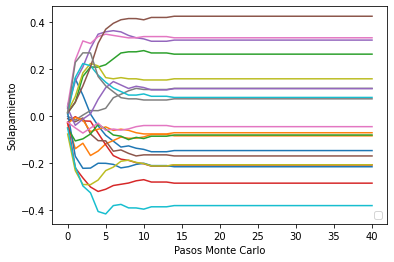

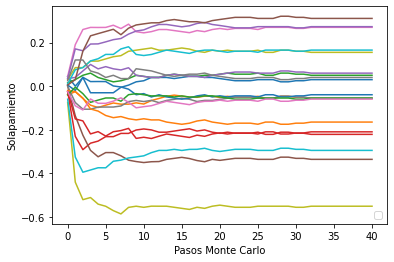

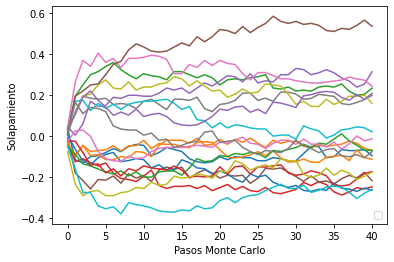

In [54]:
graficamonte(0.0001,40)
graficamonte(0.001,40)
graficamonte(0.01,40)

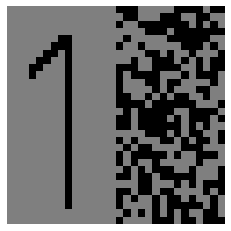

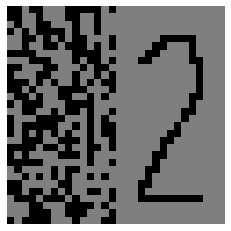

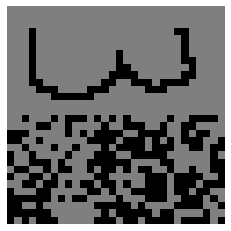

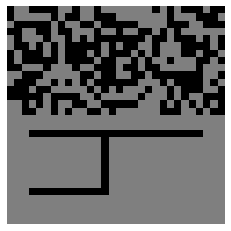

In [18]:
g=open("patron0.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(zeta[0][j][k])+", ",end="", file=g)
        else:
            print(zeta[0][j][k],end="", file=g)
    print("\n",end='',file=g)
    
g.close()
g=open("patron1.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(zeta[1][j][k])+", ",end="", file=g)
        else:
            print(zeta[1][j][k],end="", file=g)
    print("\n",end='',file=g)
    
g.close()
g=open("patron2.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(zeta[2][j][k])+", ",end="", file=g)
        else:
            print(zeta[2][j][k],end="", file=g)
    print("\n",end='',file=g)
    
g.close()

g=open("patron3.dat","w")
for j in range(npart):
    for k in range(npart):
        if(k!=npart-1):
            print(str(zeta[3][j][k])+", ",end="", file=g)
        else:
            print(zeta[3][j][k],end="", file=g)
    print("\n",end='',file=g)
    
g.close()

for i in range(4):
    nombre="patron"+str(i)+".dat"
    dibujar(nombre,i+500)

C:\Users\aula\AppData\Local\Temp\ipykernel_15372\4178986175.py:180: RuntimeWarning: overflow encountered in exp
  minimo=min(1,np.exp(-hamilton(s,n,m)/t))


4


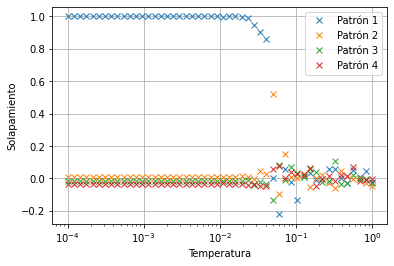

In [39]:
fig, ax = plt.subplots()
npuntos=50
temp = np.logspace(-4, 0,npuntos) # Sample data.
datos=np.zeros((p,npuntos))
for i in range(npuntos):
    datos[:,i]=main(temp[i],20,True,0.2)
print(p)    
etiqueta=["Patrón 1", "Patrón 2","Patrón 3", "Patrón 4"]
for j in range(p):
    ax.plot(temp, datos[j],'x',label=etiqueta[j])
#ax.plot(x,y)
ax.set_xlabel('Temperatura')  # Add an x-label to the axes.
ax.set_ylabel('Solapamiento')  # Add a y-label to the axes.
#plt.xlim([10**-4,6])
#plt.ylim([0.9,1])
#ax.set_title("Simple Plot")  # Add a title to the axes.
ax.legend();  # Add a legend.
#plt.savefig('1i.png')
plt.xscale("log")
plt.grid(True)